# Exploring the Ames Housing dataset

## Loading the Ames Housing dataset into a data frame

In [1]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

# Use the read_csv function with sep='\t' to read a tab-delimited file
df = pd.read_csv('AmesHousing.txt', sep='\t', usecols=columns)

# Review the top 5 rows
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [4]:
df.shape

(2930, 6)

In [5]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [6]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [7]:
# remove rows that contain missing values

df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

# Split the data into train and test

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=13)

# Separate the target variable

In [9]:
train_y = train['SalePrice']
test_y = test['SalePrice']

train_inputs = train.drop(['SalePrice'], axis=1)
test_inputs = test.drop(['SalePrice'], axis=1)

In [10]:
train_inputs['Gr Liv Area'].describe()

count    2050.000000
mean     1503.620488
std       510.851030
min       334.000000
25%      1131.250000
50%      1452.500000
75%      1737.000000
max      5642.000000
Name: Gr Liv Area, dtype: float64

<Axes: >

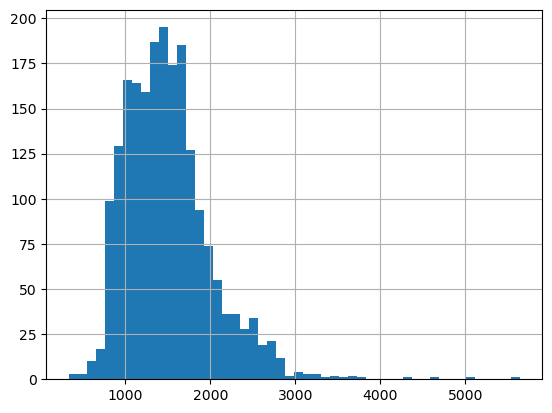

In [11]:
train_inputs['Gr Liv Area'].hist(bins=50)

In [12]:
kurt_gr_liv_area = train_inputs['Gr Liv Area'].kurtosis()
print("Kurtosis of 'Gr Liv Area':", kurt_gr_liv_area)

Kurtosis of 'Gr Liv Area': 4.954587205650682


## Create a new ordinal column: convert the Gr Liv Area to ordinal values

In [13]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['GrLivArea_binned'] = pd.cut(df1['Gr Liv Area'],
                                       bins=[0,1000,1300,1600,2000,10000],  #bins=[exclusive, inclusive]
                                       labels=False, 
                                       include_lowest=True,
                                       ordered=True)

    return df1[['GrLivArea_binned']]

In [14]:
new_col(train_inputs)

,GrLivArea_binned
2501,4
1826,0
629,3
1779,2
468,2
...,...
866,4
2791,3
74,4
2225,1


In [15]:
#Check the new distribution

new_col(train_inputs).value_counts()

GrLivArea_binned
2                   528
3                   476
1                   460
0                   305
4                   281
dtype: int64

array([[<Axes: title={'center': 'GrLivArea_binned'}>]], dtype=object)

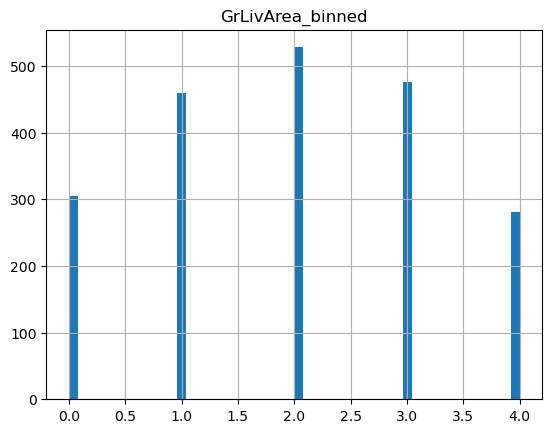

In [16]:
new_col(train_inputs).hist(bins=50)

# Identify the numeric, binary, and categorical columns

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [18]:
train_inputs.dtypes

Overall Qual       int64
Overall Cond       int64
Total Bsmt SF    float64
Central Air        int64
Gr Liv Area        int64
dtype: object

In [19]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [20]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['Central Air']

In [21]:
# We need to remove the binary columns from numerical columns.
for col in binary_columns:
    numeric_columns.remove(col)

In [22]:
binary_columns

['Central Air']

In [23]:
numeric_columns

['Overall Qual', 'Overall Cond', 'Total Bsmt SF', 'Gr Liv Area']

In [24]:
# categorical_columns

In [25]:
feat_eng_columns = ['Gr Liv Area']

In [26]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [27]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [28]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [29]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [30]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='drop')

In [31]:
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 1.33611993,  1.3345942 ,  0.62166234,  1.99006646,  1.        ,
         1.59360078],
       [-0.79101897,  0.40998517, -0.40577741, -1.17797018,  1.        ,
        -1.5689177 ],
       [-1.50006527, -1.43923288, -0.76382459,  0.45891402,  1.        ,
         0.80297116],
       ...,
       [ 0.62707363, -0.51462385, -0.24565693,  1.18728833,  1.        ,
         1.59360078],
       [-0.08197267,  0.40998517, -1.2063798 , -0.89797683,  1.        ,
        -0.77828808],
       [-0.79101897, -0.51462385, -0.43246415, -0.0482068 ,  1.        ,
         0.01234154]])

In [32]:
train_x.shape

(2050, 6)

In [33]:
test_x = preprocessor.transform(test_inputs)

test_x

array([[-0.79101897, -0.51462385, -0.95285571, -0.394772  ,  1.        ,
         0.01234154],
       [-0.79101897, -0.51462385, -0.75270511, -0.45546986,  1.        ,
        -0.77828808],
       [-0.79101897,  0.40998517, -0.13890994, -0.99391861,  1.        ,
        -1.5689177 ],
       ...,
       [-0.79101897, -0.51462385, -0.16559669, -1.01741455,  1.        ,
        -1.5689177 ],
       [-0.79101897,  0.40998517, -0.6103758 , -1.40901364,  1.        ,
        -1.5689177 ],
       [-0.79101897,  1.3345942 , -0.48583765, -1.2132141 ,  1.        ,
        -1.5689177 ]])

In [34]:
test_x.shape

(879, 6)

## Calculate the baseline

In [35]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_x, train_y)

DummyRegressor()

In [36]:
from sklearn.metrics import mean_squared_error
#Baseline Train RMSE
dummy_train_pred = dummy_regr.predict(train_x)
baseline_train_mse = mean_squared_error(train_y, dummy_train_pred)
baseline_train_rmse = np.sqrt(baseline_train_mse)
print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

Baseline Train RMSE: 80224.4993788051


In [37]:
#Baseline Test RMSE
dummy_test_pred = dummy_regr.predict(test_x)
baseline_test_mse = mean_squared_error (test_y, dummy_test_pred)
baseline_test_rmse = np.sqrt(baseline_test_mse)
print('Baseline Test RMSE: {}' .format(baseline_test_rmse))

Baseline Test RMSE: 79036.68788467893


## Try Voting Regressor with Decision Tree and Random Forest

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR 
from sklearn.ensemble import VotingRegressor

# Define the Voting Regressor parameters
dtree_reg = DecisionTreeRegressor(max_depth=10)
svm_reg = SVR(kernel="rbf") 
rnd_reg = RandomForestRegressor(max_depth=10, n_jobs=-1) 

voting_reg = VotingRegressor(
            estimators=[('dt', dtree_reg), 
                        ('svr', svm_reg), 
                        ('rnd', rnd_reg)])

voting_reg.fit(train_x, train_y)

VotingRegressor(estimators=[('dt', DecisionTreeRegressor(max_depth=10)),
                            ('svr', SVR()),
                            ('rnd',
                             RandomForestRegressor(max_depth=10, n_jobs=-1))])

In [39]:
#Train RMSE
train_pred = voting_reg.predict(train_x)
train_mse = mean_squared_error(train_y, train_pred)
train_rmse = np.sqrt(train_mse)
print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 32486.19613429494


In [40]:
#Test RMSE
test_pred = voting_reg.predict(test_x)
test_mse = mean_squared_error(test_y, test_pred)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 40550.07143912588


In [41]:
# Inspect results each classifier
for reg in (dtree_reg, svm_reg, rnd_reg, voting_reg):
    reg.fit(train_x, train_y)
    test_y_pred = reg.predict(test_x)
    print(reg.__class__.__name__, 'Test rmse=', np.sqrt(mean_squared_error(test_y, test_y_pred)))

DecisionTreeRegressor Test rmse= 36041.233106632295
SVR Test rmse= 80487.2804738696
RandomForestRegressor Test rmse= 31222.12290944958
VotingRegressor Test rmse= 40780.02140873901


In [42]:
from sklearn.preprocessing import PolynomialFeatures
# Create second degree terms and interaction terms
poly_features = PolynomialFeatures(degree=2).fit(train_x)
train_x_poly = poly_features.transform(train_x)
test_x_poly = poly_features.transform(test_x)

In [43]:
train_x_poly.shape

(2050, 28)

## Incorporating elasticnet regularization with SGDRegressor

In [44]:
from sklearn.linear_model import SGDRegressor 
elastic_net = SGDRegressor(max_iter=1000, penalty='elasticnet', l1_ratio=0.5, alpha = 95, 
                          eta0=0.01)

elastic_net.fit(train_x_poly, train_y)

SGDRegressor(alpha=95, l1_ratio=0.5, penalty='elasticnet')

In [45]:
#Train RMSE
reg_train_pred = elastic_net.predict(train_x_poly)
train_mse = mean_squared_error(train_y, reg_train_pred)
train_rmse = np.sqrt(train_mse)
print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 70904.74183254686


In [46]:
#Test RMSE
reg_test_pred = elastic_net.predict(test_x_poly)
test_mse = mean_squared_error (test_y, reg_test_pred)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 68969.96485386849


## SDGRegressor with no regularization

In [47]:
# eta0 = learning rate
# penalty = regularization term
# max_iter = number of passes over training data (i.e., epochs)

sgd_reg = SGDRegressor(max_iter=100, penalty=None, eta0=0.01) 
sgd_reg.fit(train_x, train_y)

SGDRegressor(max_iter=100, penalty=None)

In [48]:
#Train RMSE
reg_train_pred = sgd_reg.predict(train_x)
train_mse = mean_squared_error(train_y, reg_train_pred)
train_rmse = np.sqrt(train_mse)
print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 40341.48014461106


In [49]:
#Test RMSE
reg_test_pred = sgd_reg.predict(test_x)
test_mse = mean_squared_error (test_y, reg_test_pred)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 36722.81898984764


In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

forest = RandomForestRegressor(n_estimators=1000, 
                               max_depth=10,
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(train_x, train_y)
y_train_pred = forest.predict(train_x)
y_test_pred = forest.predict(test_x)

mae_train = mean_absolute_error(train_y, y_train_pred)
mae_test = mean_absolute_error(test_y, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

r2_train = r2_score(train_y, y_train_pred)
r2_test =r2_score(test_y, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 13270.92
MAE test: 21052.89
R^2 train: 0.95
R^2 test: 0.84


## Add cross validation

In [51]:
from sklearn.model_selection import cross_val_score

# Using KFold the SHORT way

# For r2 as the metric
scores_r2 = cross_val_score(estimator=forest,
                            X=train_x,
                            y=train_y,
                            cv=10,
                            scoring='r2',  # R² score for regression
                            n_jobs=-1)  # Utilizing all available CPU cores

print(f'CV R² scores: {scores_r2}')
print(f'CV R²: {np.mean(scores_r2):.3f} +/- {np.std(scores_r2):.3f}')

# For RMSE as the metric
scores_mse = cross_val_score(estimator=forest,
                             X=train_x,
                             y=train_y,
                             cv=10,
                             scoring='neg_mean_squared_error',  # Negative MSE for minimization
                             n_jobs=-1)  # Utilize all available CPU cores

# Convert negative MSE scores to positive MSE scores
scores_mse = -scores_mse

# Calculate RMSE from MSE scores
scores_rmse = np.sqrt(scores_mse)

# Print RMSE scores and their mean and standard deviation
print(f'CV RMSE scores: {scores_rmse}')
print(f'CV RMSE: {np.mean(scores_rmse):.3f} +/- {np.std(scores_rmse):.3f}')

CV R² scores: [0.8900916  0.86516047 0.85383063 0.86620746 0.82592807 0.87389759
 0.8537604  0.86064442 0.84000622 0.83493009]
CV R²: 0.856 +/- 0.018
CV RMSE scores: [27535.6229005  31007.2711248  31936.06277555 29710.65365206
 30923.76193222 28378.44342763 28659.96133526 30065.98561538
 30472.71636373 33651.2608466 ]
CV RMSE: 30234.174 +/- 1709.077


## Add a validation curve

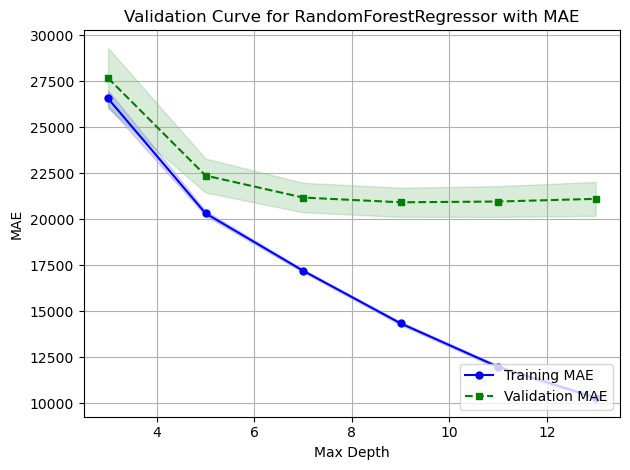

In [52]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

param_range = [3, 5, 7, 9, 11, 13]
train_scores, test_scores = validation_curve(
                estimator=forest, 
                X=train_x, 
                y=train_y, 
                param_name='max_depth', 
                param_range=param_range,
                cv=10,
                scoring='neg_mean_absolute_error', # alternative is r2
                n_jobs=-1)

train_scores = -train_scores
test_scores = -test_scores

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training MAE')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation MAE')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.title('Validation Curve for RandomForestRegressor with MAE')
plt.grid(True)
plt.xscale('linear')
plt.legend(loc='lower right')
plt.xlabel('Max Depth')
plt.ylabel('MAE')
#plt.ylim([0.25, 1.0])
plt.tight_layout()
plt.show()

## Test hyperparameters using BayesSearch on RandomForest Model

In [53]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': Integer(50, 150),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 10),
    # Add more parameters here if needed
}

rfc = RandomForestRegressor(n_jobs=-1)

bayes_search = BayesSearchCV(
    estimator=rfc,
    search_spaces=param_grid,
    n_iter=32,  # Number of iterations (parameter settings sampled)
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

bayes_search.fit(train_x, train_y)

print("Best parameters found: ", bayes_search.best_params_)
print("Best score achieved: ", bayes_search.best_score_)

best_RFmodel = bayes_search.best_estimator_

Best parameters found:  OrderedDict([('max_depth', 9), ('min_samples_split', 6), ('n_estimators', 103)])
Best score achieved:  0.852724243238333


In [54]:
test_predictions = best_RFmodel.predict(test_x)
test_mse = mean_squared_error(test_y, test_predictions)
test_rmse = np.sqrt(test_mse)
print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 31007.25076981138


In [129]:
from sklearn.model_selection import cross_val_score

# Using KFold the SHORT way

# For r2 as the metric
scores_r2 = cross_val_score(estimator=best_RFmodel,
                            X=train_x,
                            y=train_y,
                            cv=10,
                            scoring='r2',  # R² score for regression
                            n_jobs=-1)  # Utilizing all available CPU cores

print(f'CV R² scores: {scores_r2}')
print(f'CV R²: {np.mean(scores_r2):.3f} +/- {np.std(scores_r2):.3f}')

# For MAE as the metric
scores_mae = cross_val_score(estimator=best_RFmodel,
                             X=train_x,
                             y=train_y,
                             cv=10,
                             scoring='neg_mean_absolute_error', 
                             n_jobs=-1)  # Utilizing all available CPU cores

# Convert negative MAE scores to positive
scores_mae = -scores_mae

print(f'CV MAE scores: {scores_mae}')
print(f'CV MAE: {np.mean(scores_mae):.3f} +/- {np.std(scores_mae):.3f}')

CV R² scores: [0.89339165 0.86565555 0.856434   0.87118758 0.82910426 0.87386996
 0.84649372 0.86260656 0.84858165 0.83933437]
CV R²: 0.859 +/- 0.018
CV MAE scores: [20030.97055256 20503.88465823 22884.26502397 20415.83683948
 21538.62703399 20077.0928783  20350.74962049 21107.81267685
 20783.04236526 20710.22979591]
CV MAE: 20840.251 +/- 807.943


In [60]:
import pickle
filename = 'bestRF.sav'
with open(filename, 'wb') as file:
    pickle.dump(best_RFmodel, file)

In [128]:
def evaluate_model_with_cross_validation(model, X, y, num_folds=3):
    scores = cross_val_score(estimator=model,
                             X=X,
                             y=y,
                             cv=num_folds,
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1)
    scores = -scores
    mean_mae = np.mean(scores)
    std_deviation = np.std(scores)
    print('CV MAE: {:.3f} +/- {:.3f} '.format(mean_mae, std_deviation))

## Try Bagging

In [130]:
from sklearn.ensemble import BaggingRegressor
bagging_model = BaggingRegressor()
bagging_model.fit(train_x, train_y)
bagging_predictions = bagging_model.predict(test_x)
print("MAE:", mean_absolute_error(test_y, bagging_predictions))

evaluate_model_with_cross_validation(bagging_model, test_x, test_y, num_folds=3) 

MAE: 22456.474039469886
CV MAE: 22206.684 +/- 434.558 


## Try Boosting

In [131]:
from sklearn.ensemble import GradientBoostingRegressor
boosting_model = GradientBoostingRegressor()
boosting_model.fit(train_x, train_y)
boosting_predictions = boosting_model.predict(test_x)
print("MAE:", mean_absolute_error(test_y, boosting_predictions))

evaluate_model_with_cross_validation(boosting_model, test_x, test_y, num_folds=3) 

MAE: 20328.570091096866
CV MAE: 21385.130 +/- 983.898 


## Try Majority Vote

In [133]:
from sklearn.ensemble import VotingRegressor
voting_model = VotingRegressor(estimators=[('dtr', dtree_reg),
                        ('srf', forest),
                        ('svm', svm_reg), 
                        ('rf', best_RFmodel)])
voting_model.fit(train_x, train_y)
voting_predictions = voting_model.predict(test_x)
print("MAE:", mean_absolute_error(test_y, voting_predictions))

evaluate_model_with_cross_validation(voting_model, test_x, test_y, num_folds=3) 

MAE: 24451.003592139692
CV MAE: 24933.167 +/- 484.004 


## Try Stacking

In [135]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

estimators = [('dtr', dtree_reg), ('srf', forest), ('svm', svm_reg), ('rf', best_RFmodel)]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=10,random_state=42))
stacking_model.fit(train_x, train_y)
stacking_predictions = stacking_model.predict(test_x)
print("MAE:", mean_absolute_error(test_y, stacking_predictions))

evaluate_model_with_cross_validation(stacking_model, test_x, test_y, num_folds=3) 

MAE: 23607.861509290862
CV MAE: 24093.898 +/- 629.723 


## Apply unsupervised learning with Kmeans clustering

In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#clstrdf = df.drop(['SalePrice'], axis=1)
clstrdf = df

In [62]:
clstrdf = preprocessor.fit_transform(clstrdf)
clstrdf.shape

(2929, 6)

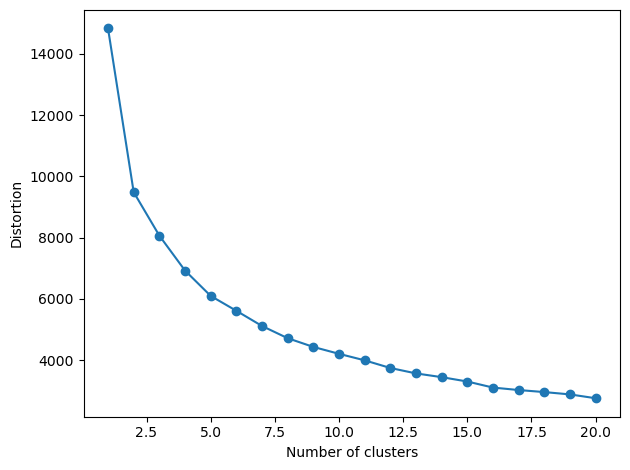

In [63]:
distortions = []
for i in range(1, 21):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(clstrdf)
    distortions.append(km.inertia_)
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('figures/km-elbow.png', dpi=300)
plt.show()

In [64]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, tol=1e-04, random_state=42)
clusters = kmeans.fit_predict(clstrdf)

In [65]:
# Add the cluster labels to the dataframe
df['Cluster'] = clusters

# Analyze cluster counts
print(df['Cluster'].value_counts())

# Explore characteristics of each cluster
print(df.groupby('Cluster').mean())

1    1578
0    1351
Name: Cluster, dtype: int64
         Overall Qual  Overall Cond  Total Bsmt SF  Central Air  Gr Liv Area  \
Cluster                                                                        
0            7.051813      5.284974    1296.475204     0.969652  1888.391562   
1            5.276933      5.800380     841.977820     0.901774  1167.287706   

             SalePrice  
Cluster                 
0        236285.703183  
1        133353.276933  


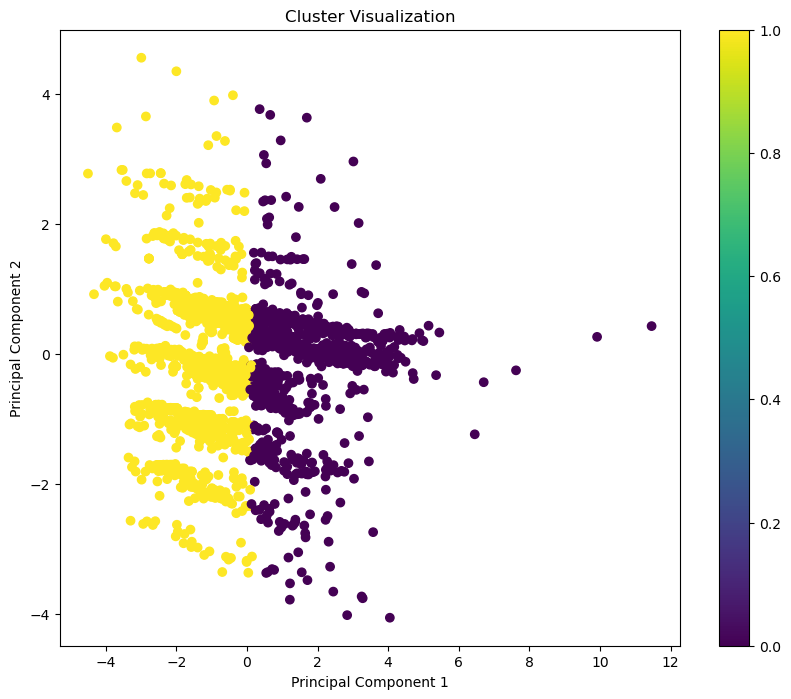

In [66]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(clstrdf)
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.colorbar()
plt.show()

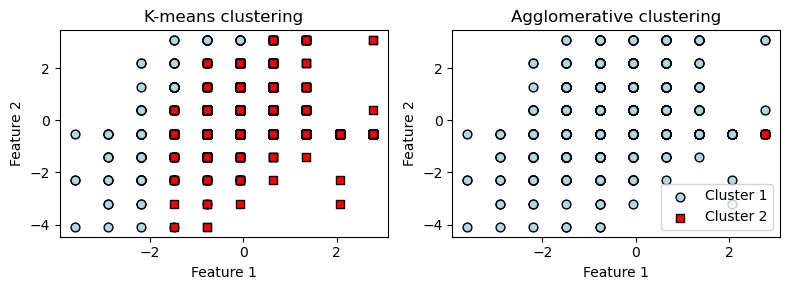

In [67]:
from sklearn.cluster import AgglomerativeClustering

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(clstrdf)
ax1.scatter(clstrdf[y_km == 0, 0], clstrdf[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(clstrdf[y_km == 1, 0], clstrdf[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(clstrdf)
ax2.scatter(clstrdf[y_ac == 0, 0], clstrdf[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(clstrdf[y_ac == 1, 0], clstrdf[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')

ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.legend()
plt.tight_layout()
#plt.savefig('figures/10_15.png', dpi=300)
plt.show()

## Visualizing the important characteristics of a dataset

In [70]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

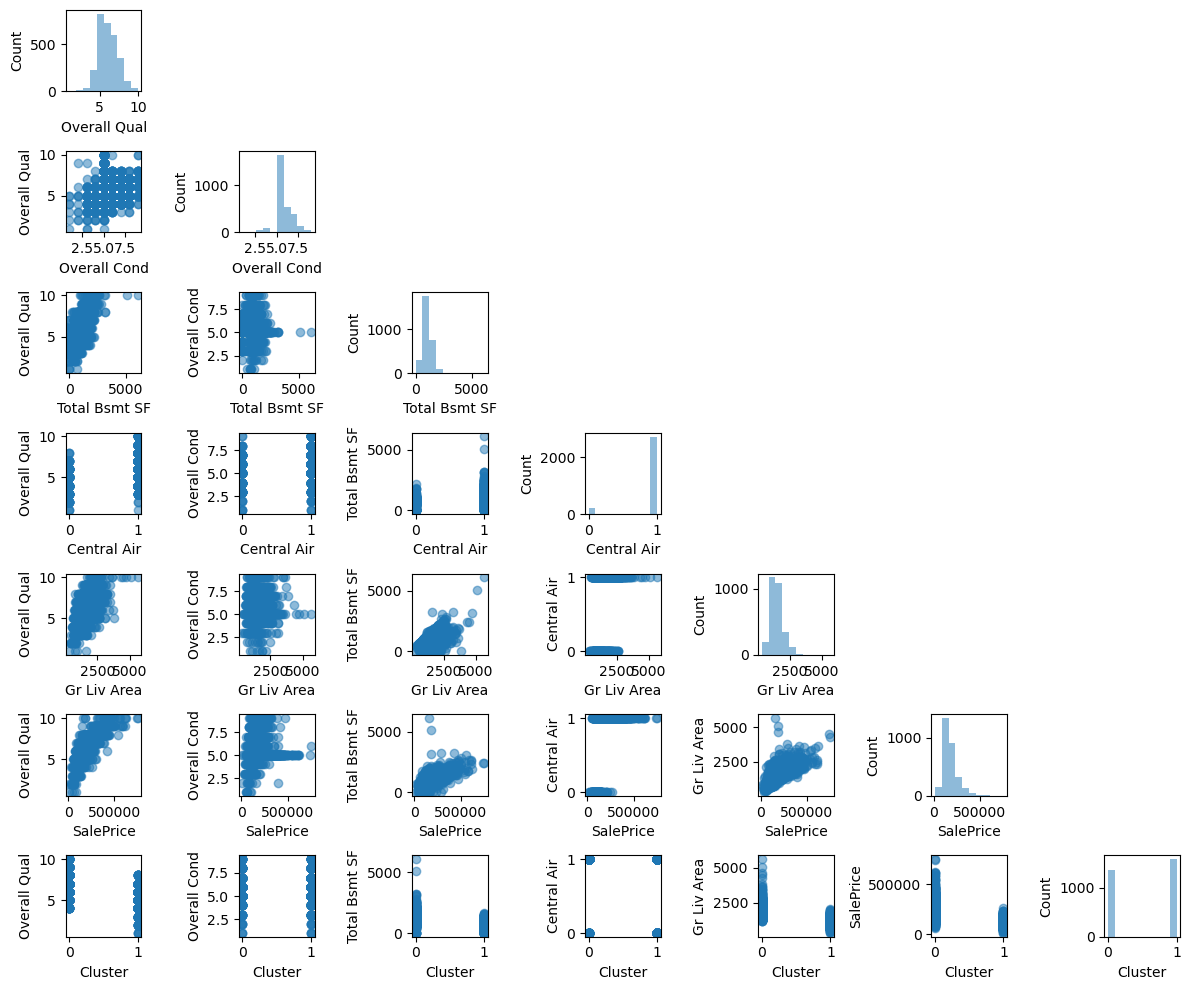

In [71]:
scatterplotmatrix(df.values, figsize=(12, 10), 
                  names=df.columns, alpha=0.5)
plt.tight_layout()
#plt.savefig('figures/09_04.png', dpi=300)
plt.show()

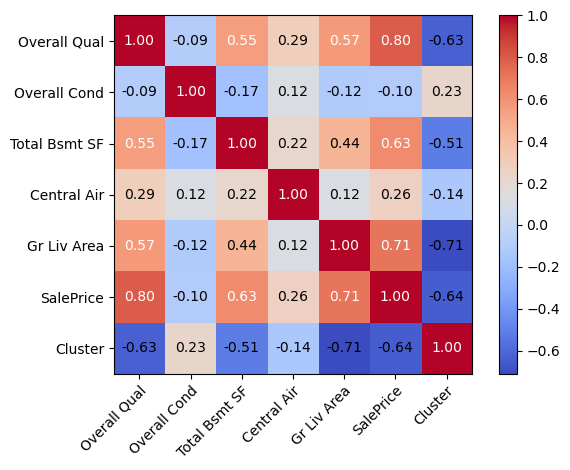

In [72]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns, cmap='coolwarm')

plt.tight_layout()
#plt.savefig('figures/09_05.png', dpi=300)
plt.show()

# Implementing an ordinary least squares linear regression model

## Solving regression for regression parameters with gradient descent

In [73]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

In [74]:
X = df[['Gr Liv Area']].values

y = df['SalePrice'].values

In [75]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [76]:
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

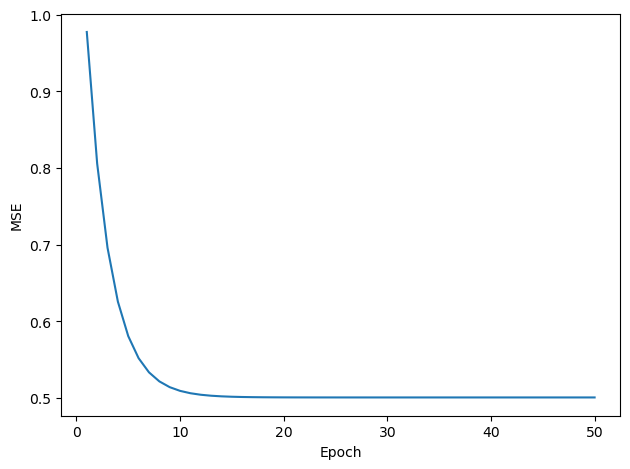

In [77]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
#plt.savefig('figures/09_06.png', dpi=300)
plt.show()

In [78]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

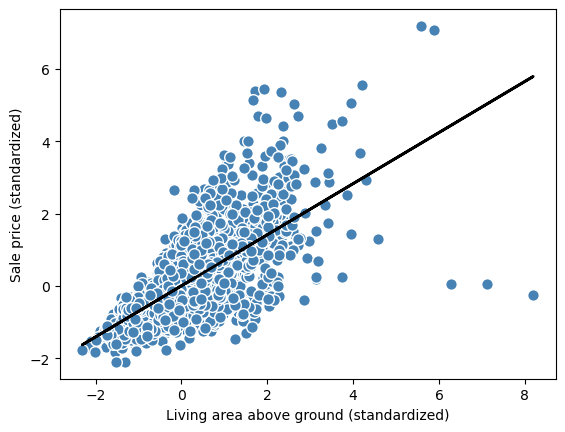

In [79]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

#plt.savefig('figures/09_07.png', dpi=300)
plt.show()

In [80]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price: ${target_reverted.flatten()[0]:.2f}')

Sale price: $292507.07


In [81]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


## Estimating the coefficient of a regression model via scikit-learn

In [82]:
from sklearn.linear_model import LinearRegression

In [83]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


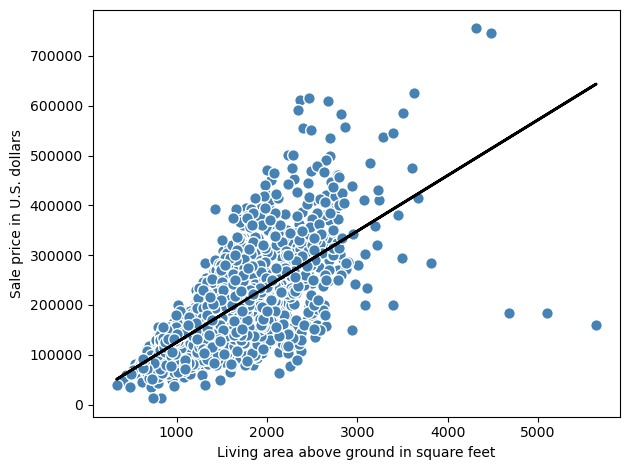

In [84]:
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_08.png', dpi=300)
plt.show()

**Normal Equations** alternative:

In [85]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print(f'Slope: {w[1]:.3f}')
print(f'Intercept: {w[0]:.3f}')

Slope: 111.666
Intercept: 13342.979


# Fitting a robust regression model using RANSAC

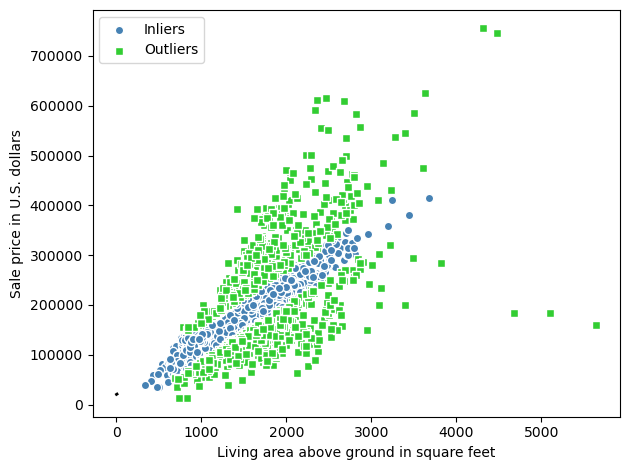

In [86]:
from sklearn.linear_model import RANSACRegressor


ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, # default
                         min_samples=0.95, 
                         loss='absolute_error', # default
                         residual_threshold=None, # default 
                         random_state=123)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_09.png', dpi=300)
plt.show()

In [87]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


In [88]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))
    
median_absolute_deviation(y)

37000.0

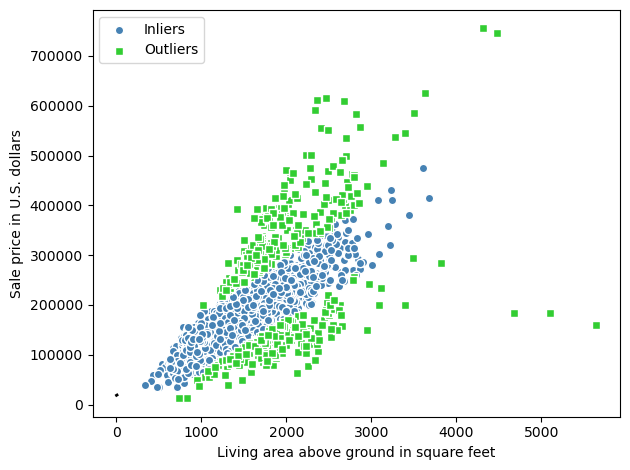

In [89]:
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, # default
                         min_samples=0.95, 
                         loss='absolute_error', # default
                         residual_threshold=65000, # default 
                         random_state=123)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_10.png', dpi=300)
plt.show()

In [90]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 105.631
Intercept: 18314.587


# Evaluating the performance of linear regression models

In [91]:
from sklearn.model_selection import train_test_split


target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [92]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

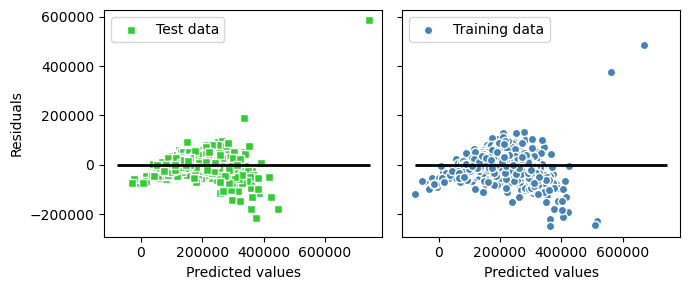

In [93]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_11.png', dpi=300)
plt.show()

In [94]:
from sklearn.metrics import mean_squared_error


mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)


print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1492444140.36
MSE test: 1527598719.67


In [95]:
from sklearn.metrics import mean_absolute_error


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25931.35
MAE test: 24837.57


In [96]:
from sklearn.metrics import r2_score


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

R^2 train: 0.77
R^2 test: 0.75


In [97]:
coefs=slr.coef_
for feature, coef in zip(features, coefs):
    print(f"{feature}: {coef}")

Overall Qual: 26889.99879680452
Overall Cond: 393.1453925152761
Total Bsmt SF: 43.12818365517002
Central Air: 11151.91183655801
Gr Liv Area: 59.09322285725819
Cluster: 7034.712642033501


# Using regularized methods for regression

In [98]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[26888.96177297   393.55651447    43.12867253 11136.37550117
    59.0885151   7024.33858792]


In [99]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {train_mse:.3f}, test: {test_mse:.3f}')

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

MSE train: 1492444166.904, test: 1527586750.957
R^2 train: 0.770, 0.750


Ridge regression:

In [100]:
from sklearn.linear_model import Ridge


ridge = Ridge(alpha=1.0)

LASSO regression:

In [101]:
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=1.0)

Elastic Net regression:

In [102]:
from sklearn.linear_model import ElasticNet


elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Turning a linear regression model into a curve - polynomial regression

In [103]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [104]:
from sklearn.preprocessing import PolynomialFeatures


lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

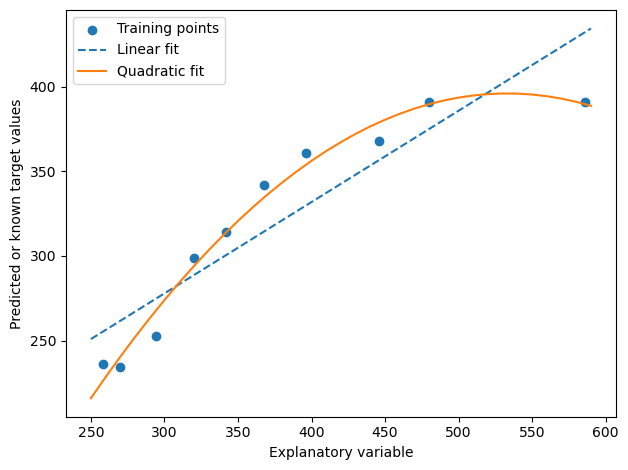

In [105]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_12.png', dpi=300)
plt.show()

In [106]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [107]:
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')


r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
      f', quadratic: {r2_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Ames Housing dataset

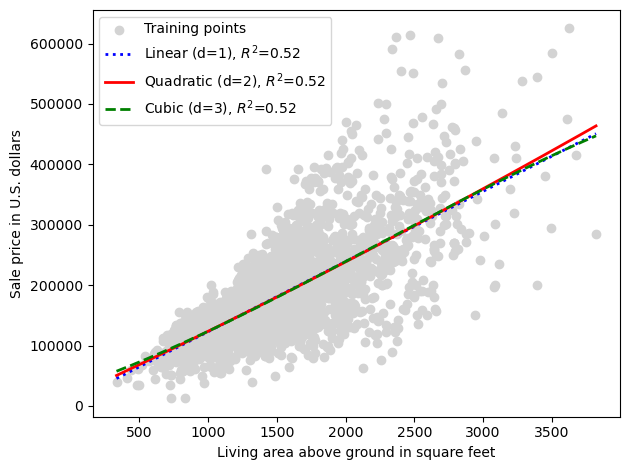

In [108]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]


regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('09_13.png', dpi=300)
plt.show()

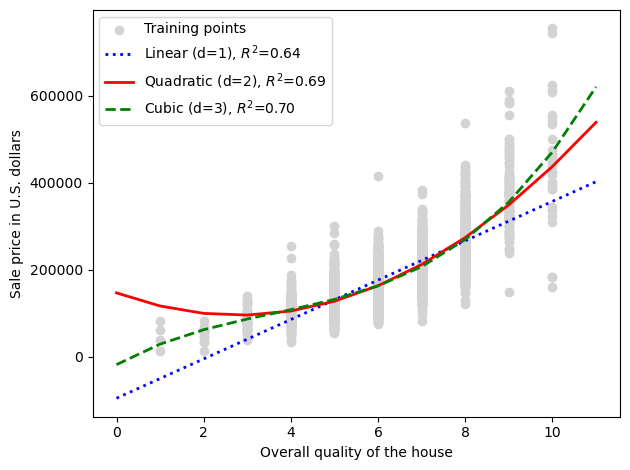

In [109]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values


regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Overall quality of the house')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('09_14.png', dpi=300)
plt.show()

# Dealing with nonlinear relationships using random forests

## Decision tree regression

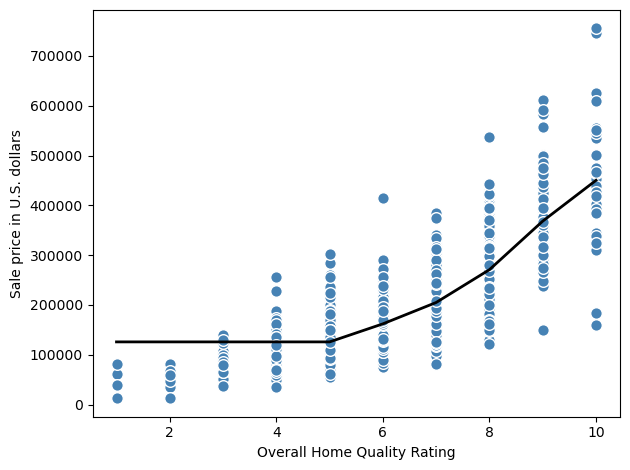

In [110]:
from sklearn.tree import DecisionTreeRegressor

X = df[['Overall Qual']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Overall Home Quality Rating')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
#plt.savefig('figures/09_15.png', dpi=300)
plt.show()

In [111]:
tree_r2 = r2_score(y, tree.predict(X))
#tree_r2
print(f'R^2: {tree_r2:.2f}')

R^2: 0.69


## Random forest regression

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(train_x, train_y)
y_train_pred = forest.predict(train_x)
y_test_pred = forest.predict(test_x)

mae_train = mean_absolute_error(train_y, y_train_pred)
mae_test = mean_absolute_error(test_y, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

r2_train = r2_score(train_y, y_train_pred)
r2_test =r2_score(test_y, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 8385.16
MAE test: 21344.32
R^2 train: 0.98
R^2 test: 0.84


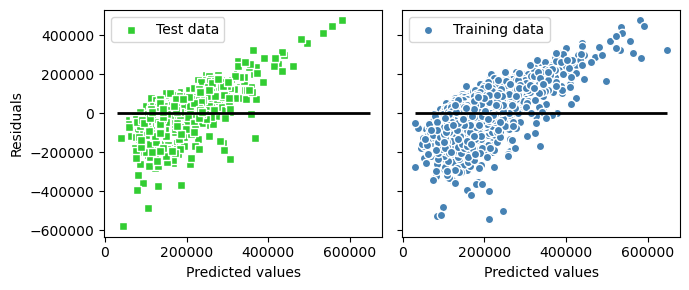

In [113]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_16.png', dpi=300)
plt.show()

In [114]:
import pickle

In [115]:
file = 'model.sav'
pickle.dump(forest, open(file, 'wb'))

In [116]:
feature_imp = pd.DataFrame(
{'importance':forest.feature_importances_},
index=features)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Overall Qual,0.662536
Central Air,0.193622
Total Bsmt SF,0.115821
Overall Cond,0.018551
Gr Liv Area,0.007375
Cluster,0.002094


In [118]:
input_data=pd.DataFrame({
    'Overall Qual':[5],
    'Overall Cond':[5],
    'Gr Liv Area':[1500],
    'Central Air':[1],
    'Total Bsmt SF':[1000]
})

In [119]:
model = pickle.load(open('model.sav', 'rb'))